In [68]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from shapely.geometry import Point, LineString, Polygon

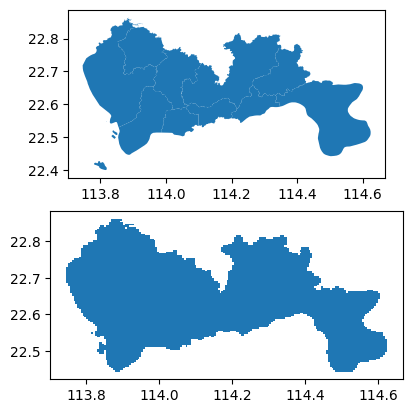

,start_lon_index,start_lat_index,end_lon_index,end_lat_index,vehicle_num
0,63,17,65,16,298
1,75,21,74,19,275
2,63,18,65,16,235
3,76,21,74,19,173
4,65,17,63,18,172


In [76]:
shape = gpd.GeoDataFrame.from_file(
    r'../shapefile/sz.shp',
    encoding='utf-8'
)
grid = gpd.GeoDataFrame.from_file(
    r'../shapefile/grid/grid.shp',
    encoding='gbk'
)
# 绘制子图
fig, ax = plt.subplots(2, 1)
shape.plot(ax=ax[0])
grid.plot(ax=ax[1])
plt.show()

shape['centroid'] = shape.apply(lambda x: Point(x['centroid_x'], x['centroid_y']), axis=1)
shape = shape.rename(columns={
    'qh': 'area'
})
shape = shape[
    ['area', 'centroid', 'geometry']
]
# 读取出租车行驶数据
OD = pd.read_csv(r'../data-sample/taxi_od_grid.csv')
OD = OD.rename(columns={
    'SLONCOL': 'start_lon_index',
    'SLATCOL': 'start_lat_index',
    'ELONCOL': 'end_lon_index',
    'ELATCOL': 'end_lat_index',
    'VehicleNum': 'vehicle_num'
})
OD.head()

In [70]:
# 获取栅格的几何中心
grid_point = grid.copy()
grid_point['geometry'] = grid_point.centroid
# how=inner, 使用内连接，op=intersects，相交拓扑规则
grid_point = gpd.sjoin(grid_point, shape, how='inner', op='intersects')
grid_point = grid_point.rename(columns={
    'LONCOL': 'lon_index',
    'LATCOL': 'lat_index',
    'index_right': 'area_index'
})
grid_point = grid_point[[
    'lon_index', 'lat_index', 'geometry', 'area_index'
]]
grid_point.head()

d:\Repository\conda\envs\map\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,lon_index,lat_index,geometry,area_index
2,0,56,POINT (113.74950 22.69740),3
3,0,57,POINT (113.74950 22.70190),3
4,0,58,POINT (113.74950 22.70639),3
5,0,59,POINT (113.74950 22.71089),3
6,0,60,POINT (113.74950 22.71539),3


In [71]:
# 抽取跨区域移动的OD
# 起始栅格参照
grid_start = grid_point.rename(columns={
    'lon_index': 'start_lon_index',
    'lat_index': 'start_lat_index',
    'area_index' : 'start_area_index'
})
# 终止点栅格参照
grid_end = grid_point.rename(columns={
    'lon_index': 'end_lon_index',
    'lat_index': 'end_lat_index',
    'area_index' : 'end_area_index'
})
# 合并
od_index = OD.merge(grid_start, on=['start_lon_index', 'start_lat_index'])
od_index = od_index.merge(grid_end, on=['end_lon_index', 'end_lat_index'])
# 去除非跨区域项
od_index = od_index[-(od_index['start_area_index']==od_index['end_area_index'])]
# 构造路径
od_index['geometry'] = od_index.apply(lambda x : LineString([
    x['geometry_x'], x['geometry_y']
]), axis=1)
od_index = od_index[
    ['vehicle_num', 'start_area_index', 'end_area_index', 'geometry']
]
od_index = gpd.GeoDataFrame(od_index)
od_index.head()

,vehicle_num,start_area_index,end_area_index,geometry
1,139,0,1,"LINESTRING (114.11495 22.54002, 114.06622 22.5..."
3,89,0,1,"LINESTRING (114.11982 22.54002, 114.06622 22.5..."
5,41,0,1,"LINESTRING (114.12469 22.54901, 114.06622 22.5..."
6,36,0,1,"LINESTRING (114.11008 22.53102, 114.06622 22.5..."
7,41,0,1,"LINESTRING (114.11982 22.54451, 114.06622 22.5..."


C:\Users\13191\AppData\Local\Temp\ipykernel_36656\1553833982.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('autumn_r')


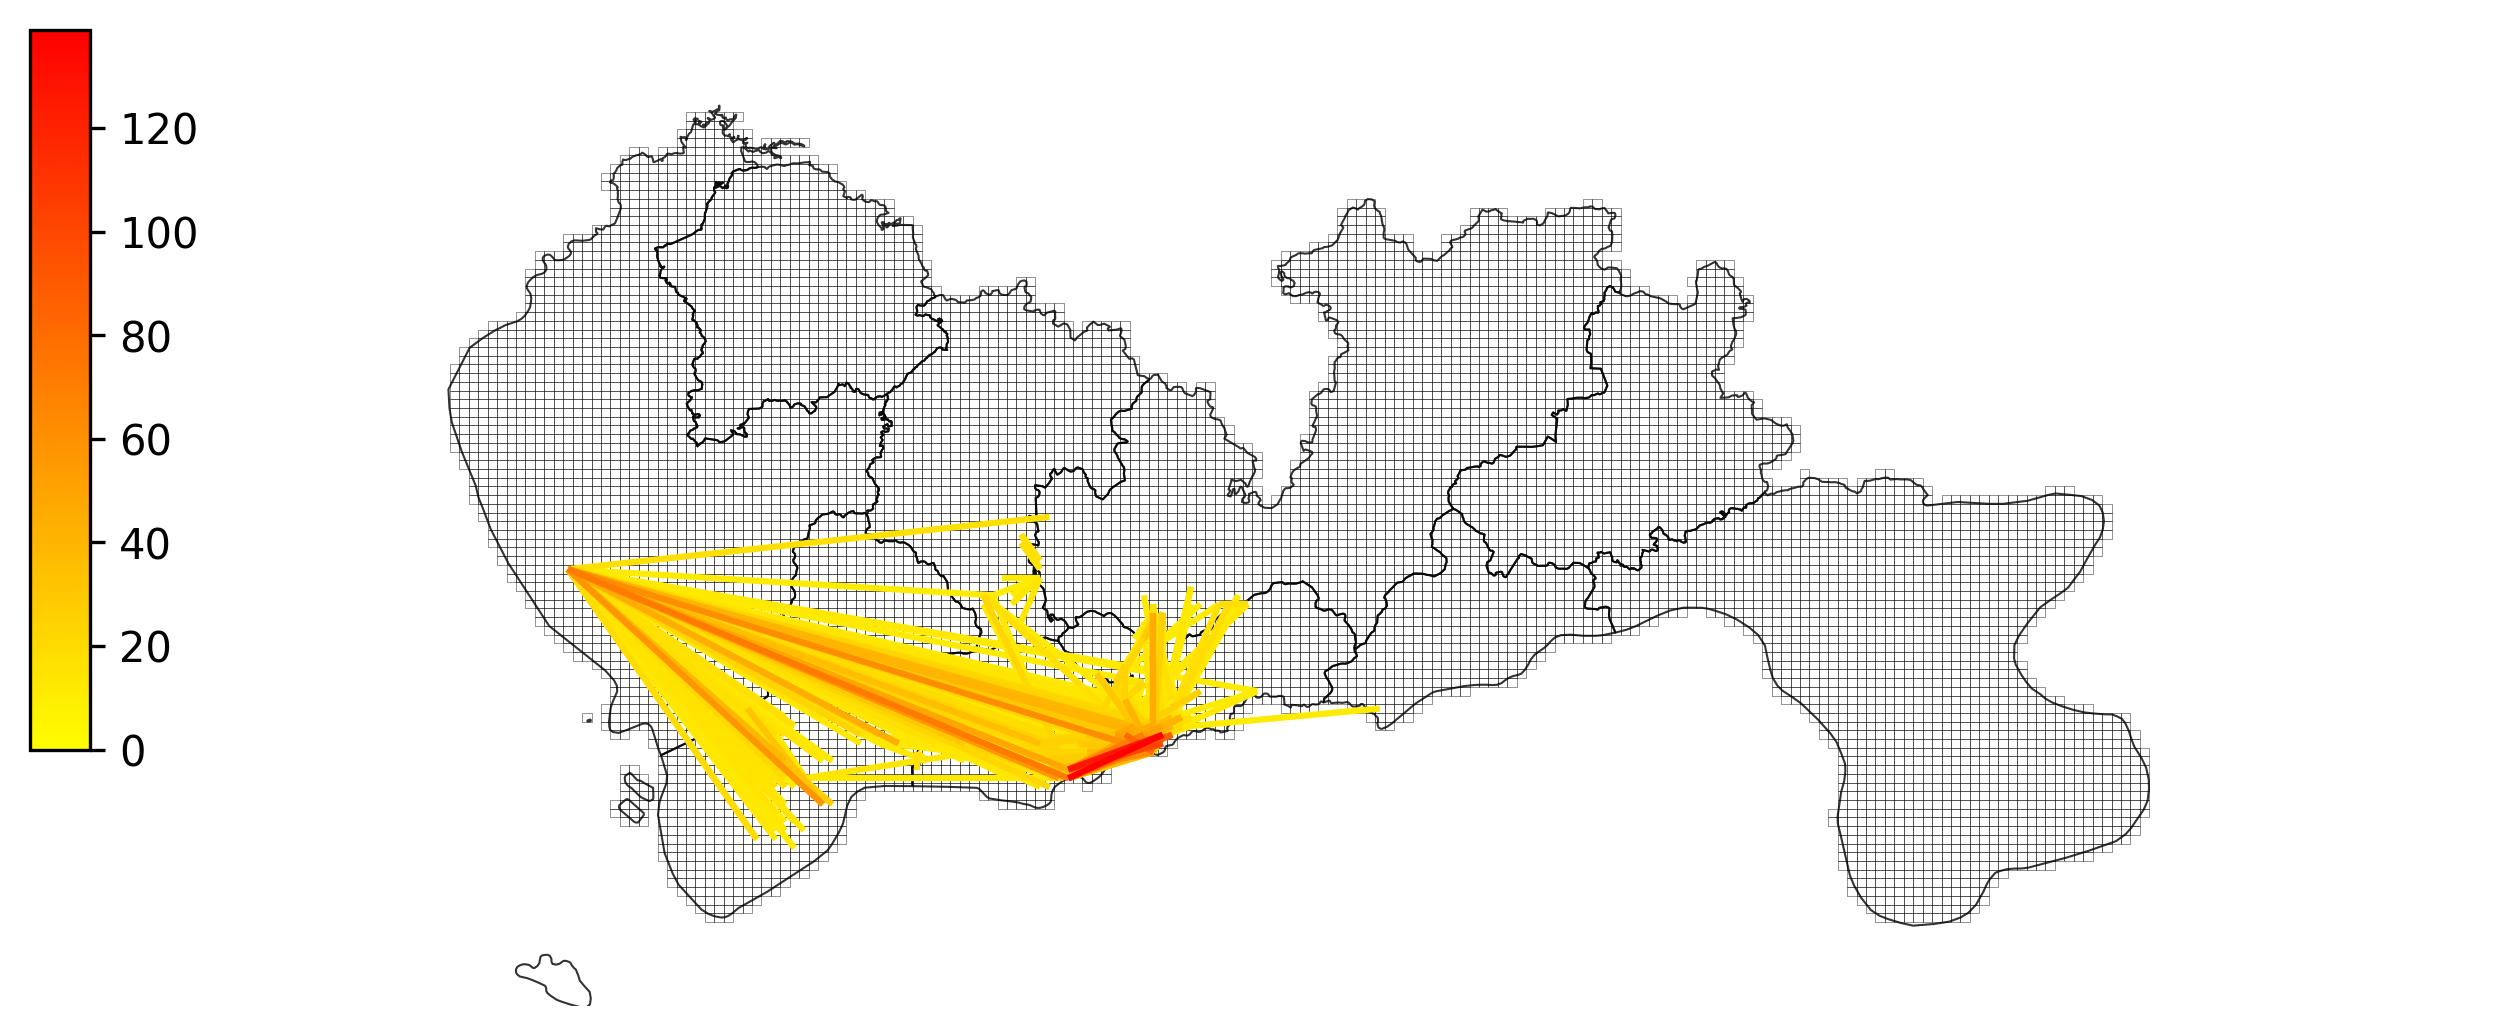

In [115]:
def plot_od(od, threshold=10):
    fig = plt.figure(1, (10, 8), dpi=300)
    ax = plt.subplot(111)
    plt.sca(ax)
    # 设定筛选阈值，并排序，使得vehicle_num较大的od后绘制
    temp_od = od[(od['vehicle_num']>threshold)].sort_values(by='vehicle_num')
    # 背景绘制
    grid.plot(ax=ax, edgecolor=(0, 0, 0, 0.5), facecolor=(0, 0, 0, 0), linewidths=0.2)
    shape.plot(ax=ax, edgecolor=(0, 0, 0, 0.8), facecolor=(0, 0, 0, 0), linewidth=0.5)
    # 色表
    vmax = od['vehicle_num'].max()
    # 归一化
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    cmap = mpl.cm.get_cmap('autumn_r')
    temp_od.plot(ax=ax, column='vehicle_num', norm=norm, cmap=cmap)
    # 关闭坐标轴
    plt.axis('off')
    plt.imshow([[0,vmax]], cmap=cmap)
    cax = plt.axes([0.08, 0.4, 0.02, 0.3])
    plt.colorbar(cax=cax)
    ax.set_xlim(113.6,114.8)
    ax.set_ylim(22.4,22.9)

plot_od(od_index)

In [110]:
import numpy as np
od_group = od_index.groupby(['start_area_index', 'end_area_index'], as_index=False)['vehicle_num'].sum()
shape_begin = shape.rename(columns={
    'area': 'begin_area',
    'centroid': 'begin_centroid'
})
shape_end = shape.rename(columns={
    'area': 'end_area',
    'centroid': 'end_centroid'
})
od_area = pd.merge(shape_begin, od_group, right_on='start_area_index', left_index=True)
od_area = pd.merge(shape_end, od_area, right_on='end_area_index', left_index=True)
od_area['geometry'] = od_area.apply(
    lambda x: LineString([x['begin_centroid'], x['end_centroid']]),
    axis=1
)
od_area = od_area[
    ['begin_area', 'end_area', 'geometry', 'vehicle_num']
]
od_area.head()

,begin_area,end_area,geometry,vehicle_num
9,福田,罗湖,"LINESTRING (114.04153 22.54618, 114.14316 22.5...",22189
18,盐田,罗湖,"LINESTRING (114.27021 22.59643, 114.14316 22.5...",559
26,宝安,罗湖,"LINESTRING (113.85139 22.67912, 114.14316 22.5...",1103
34,光明,罗湖,"LINESTRING (113.92629 22.76616, 114.14316 22.5...",2
40,坪山,罗湖,"LINESTRING (114.35694 22.69102, 114.14316 22.5...",1


C:\Users\13191\AppData\Local\Temp\ipykernel_36656\1553833982.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('autumn_r')


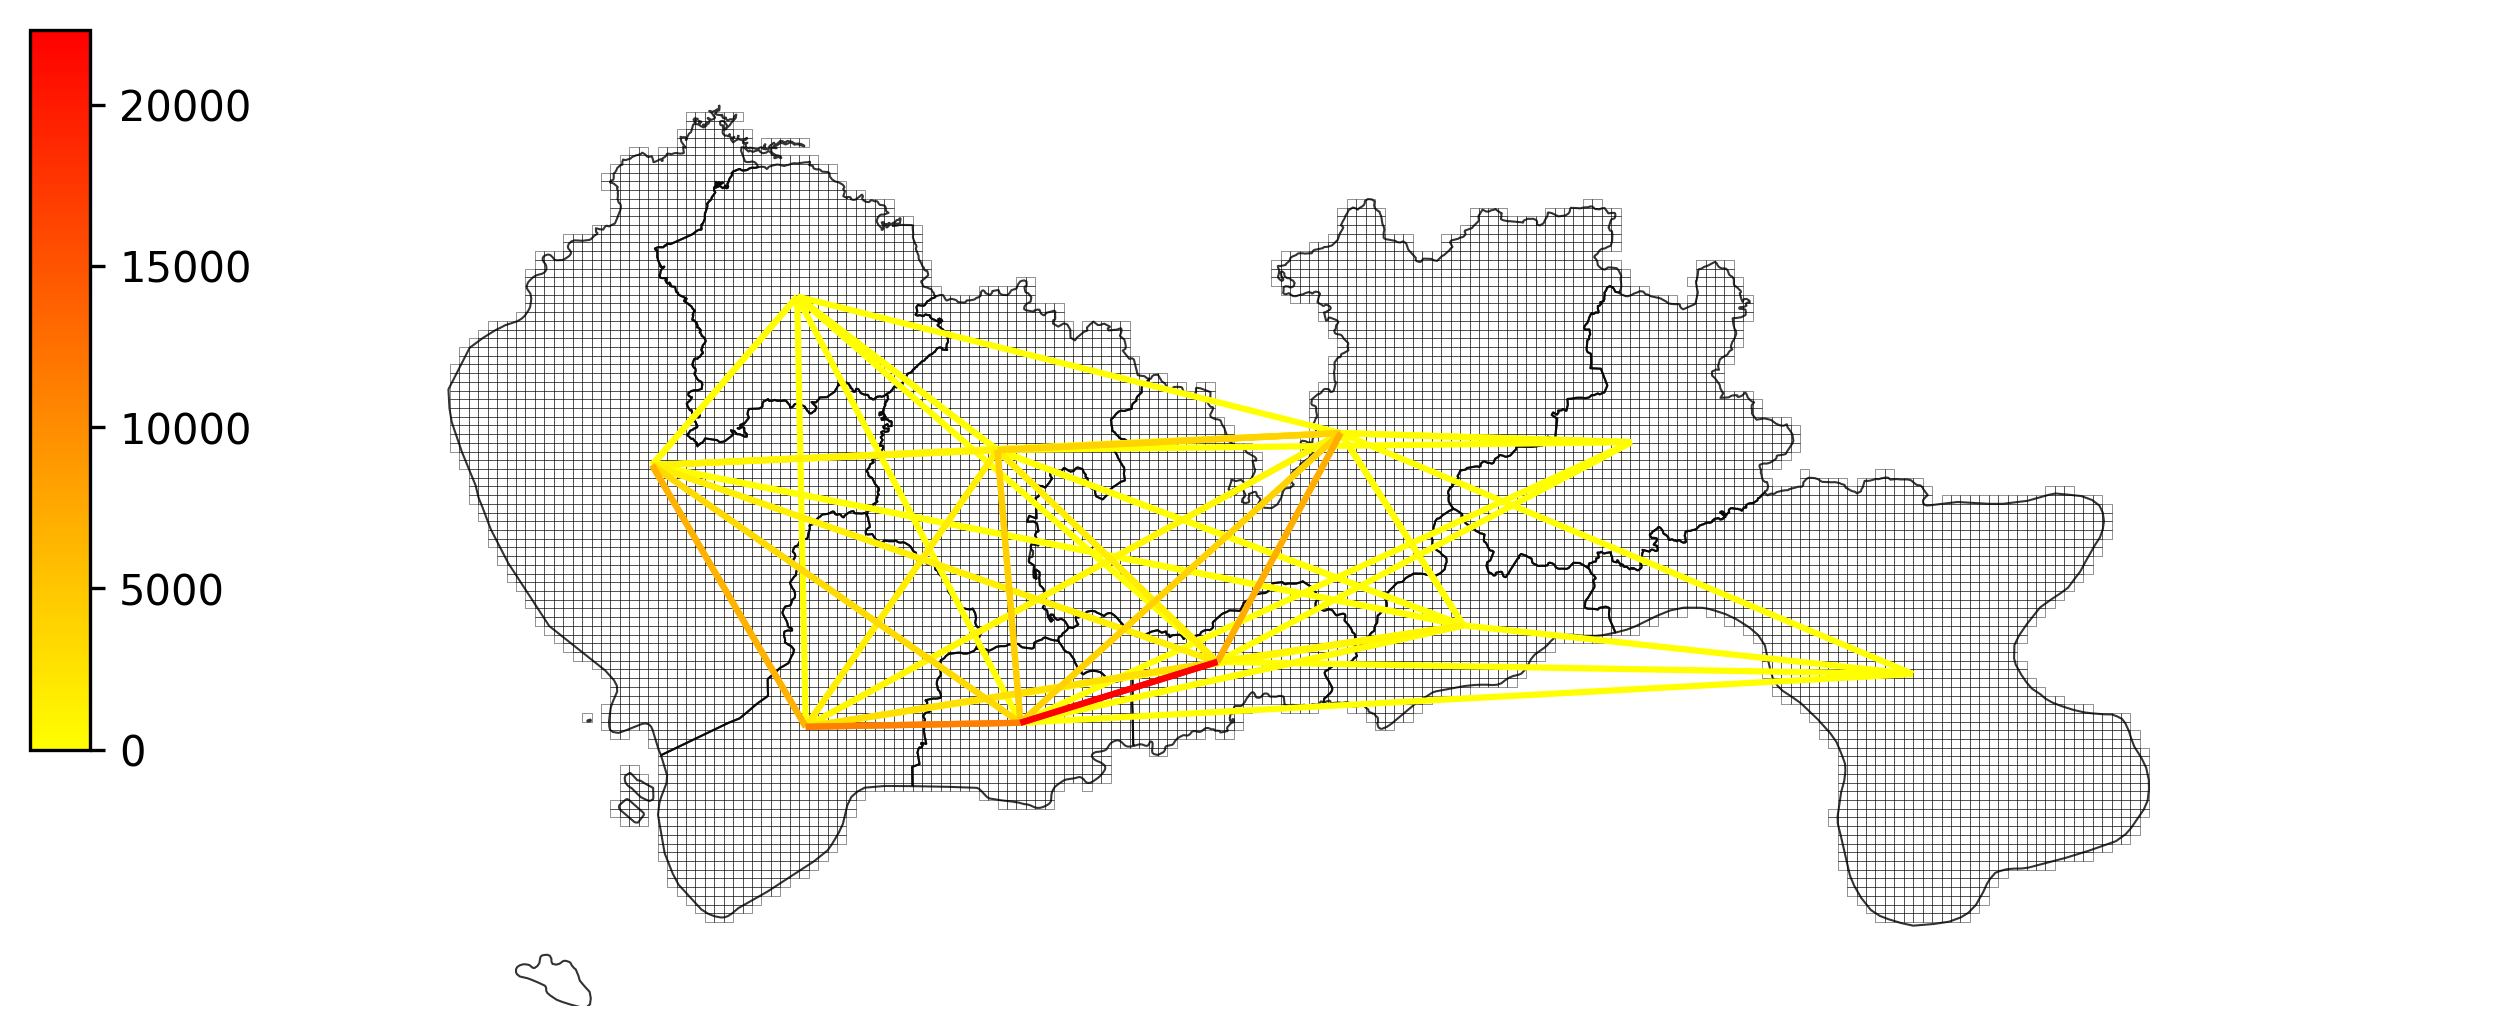

In [116]:
plot_od(od_area)